## Importing libraries

In [20]:
from utilities.transfrom import data_transform
from utilities.modeling import Model
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

sns.set_style("ticks")

In [3]:
# Import and transfrom the data in accordance to conslusions made in '1_Data'
df = pd.read_csv("./data/train.csv")
df_train = data_transform(df)

In [4]:
# Printing the heads
df_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22,7.2500,0,0,1,0,1,1
1,1,38,71.2833,0,0,0,0,0,0
2,1,26,7.9250,1,0,1,0,1,0
3,1,35,53.1000,0,0,0,0,1,0
4,0,35,8.0500,1,0,1,0,1,1


In [5]:
df_train.dtypes

Survived         int32
Age              int32
Fare           float64
TravelAlone      int32
Pclass_2         int32
Pclass_3         int32
Embarked_Q       int32
Embarked_S       int32
Sex_male         int32
dtype: object

## ML model: Random Forest

In [6]:
# Predictors
X = df_train[['Age', 'Fare', 'TravelAlone', 'Pclass_2', 'Pclass_3','Embarked_Q', 'Embarked_S', 'Sex_male']]

# Dependent variable
y = df_train["Survived"]

### Random Forest (Grid search combined with recursive feature elimination)

To alleviate the computer's workload, certain portions of the code related to GridCV and RFECV have been encapsulated within functions and executed only once.
The model with optimized hyperparametrs and stored as variables: **model** and **features**.

In [7]:
# Function to perform grid search with cross-validation
def grid_search(model: object, mapping_template: dict, cross_validation, fitting: tuple) -> object: 
    grid = GridSearchCV(estimator=model, param_grid=mapping_template, cv=cross_validation, scoring=["accuracy", "roc_auc"], refit="accuracy")
    grid.fit(*fitting)
    
    print(grid.best_estimator_.__str__())
    print(f"Accuracy: {grid.best_score_.round(3)}")
    for key, value in grid.best_params_.items():
        print(f"{key}: {value}")
    
    return grid.best_estimator_

# cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [10]:
# Grid search iteration: 1
mapping = {
    'criterion': ['entropy', 'gini'], # The function to measure the quality of a split
    'n_estimators': [50, 100, 150], # Number of estimators
    'max_depth': [2, 4, 8, 16, 32], # Maximum depth of the tree
    'min_samples_split': [2, 4, 8, 16, 32], # Minimum samples required to split an internal node
    'min_samples_leaf': [2, 4, 8, 16, 32] # Minimum number of samples required to be at a leaf node
    }

# grid_search(model=RandomForestClassifier(random_state=42), mapping_template=mapping, cross_validation=skf, fitting=(X,y))

# RandomForestClassifier(max_depth=32, min_samples_leaf=2, n_estimators=50,
#                        random_state=42)
# Accuracy: 0.834
# criterion: gini
# max_depth: 32
# min_samples_leaf: 2
# min_samples_split: 2
# n_estimators: 50

In [12]:
# Grid search iteration: 2
mapping = {
    'criterion': ['gini'], # The function to measure the quality of a split
    'n_estimators': [25, 50, 75], # Number of estimators
    'max_depth': [20, 32, 40], # Maximum depth of the tree
    'min_samples_split': [2, 4, 8], # Minimum samples required to split an internal node
    'min_samples_leaf': [2, 4, 8] # Minimum number of samples required to be at a leaf node
    }

# grid_search(model=RandomForestClassifier(random_state=42), mapping_template=mapping, cross_validation=skf, fitting=(X,y))

# RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=50,
#                        random_state=42)
# Accuracy: 0.835
# criterion: gini
# max_depth: 20
# min_samples_leaf: 2
# min_samples_split: 2
# n_estimators: 50

In [16]:
# Grid search iteration: 3
mapping = {
    'criterion': ['gini'], # The function to measure the quality of a split
    'n_estimators': [40, 50, 60], # Number of estimators
    'max_depth': [15, 20, 25], # Maximum depth of the tree
    'min_samples_split': [2, 4], # Minimum samples required to split an internal node
    'min_samples_leaf': [2, 4] # Minimum number of samples required to be at a leaf node
    }

# grid_search(model=RandomForestClassifier(random_state=42), mapping_template=mapping, cross_validation=skf, fitting=(X,y))

# RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=40,
#                        random_state=42)
# Accuracy: 0.836
# criterion: gini
# max_depth: 20
# min_samples_leaf: 2
# min_samples_split: 2
# n_estimators: 40

model_grid = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=40, random_state=42)

# Recursive feature elimination

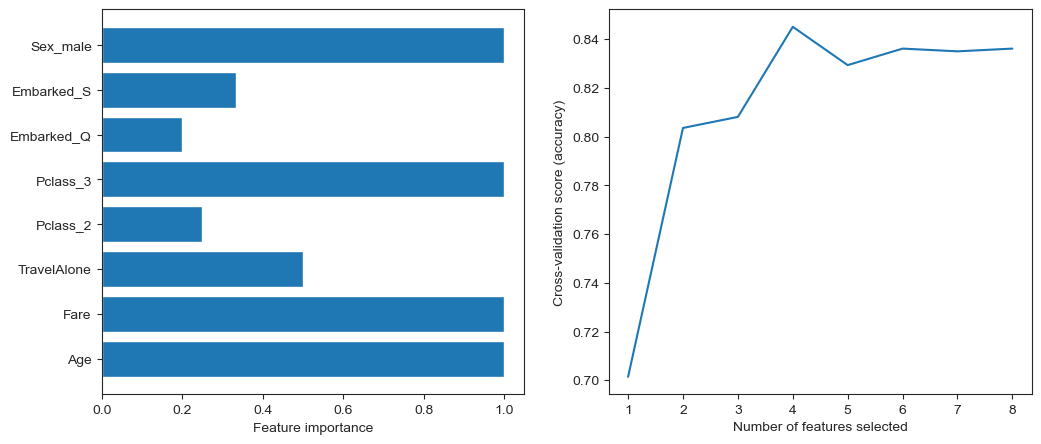

In [22]:
# Function to perform recursive feature elimination with cross-validation
def rfecv(model: object, cross_validation, fitting: tuple) -> list[str]:
    rfe_cv = RFECV(estimator=model, step=1, cv=cross_validation, scoring="accuracy")
    rfe_cv.fit(*fitting)
    
    # Graphs
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax = axes[0]
    ax.barh(rfe_cv.feature_names_in_, 1 / rfe_cv.ranking_)
    ax.set_xlabel("Feature importance")

    ax = axes[1]
    ax.plot(range(1, len(rfe_cv.cv_results_["mean_test_score"]) + 1), rfe_cv.cv_results_["mean_test_score"])
    ax.set_xlabel("Number of features selected")
    ax.set_ylabel("Cross-validation score (accuracy)")

    plt.show()

    # Feautures
    features = [i for i in rfe_cv.get_feature_names_out()]
    return features

rfecv(model=model_grid,
      cross_validation=skf,
      fitting=(X,y))

features_rfecv = ['Age', 'Fare', 'Pclass_3', 'Sex_male']

In [19]:
# Dictionary o parameters without random_state key
params = model_grid.get_params()
params.pop('random_state')
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 40,
 'n_jobs': None,
 'oob_score': False,
 'verbose': 0,
 'warm_start': False}

In [23]:
# Model cross-validation
model = Model(model=RandomForestClassifier, X_domain=X[features_rfecv], y_domain=y, cross_validator=skf)
model.cross_validation_(kwargs=params)
model

Model(model_name='RandomForestClassifier', accuracy=0.838, precission=0.825, roc_auc=0.864, f1=0.775, recall=0.736)

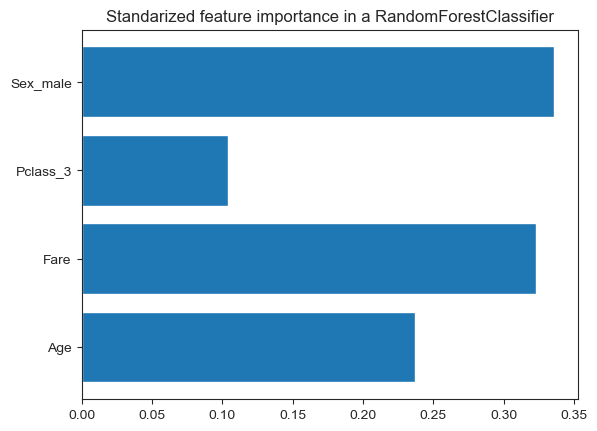

In [25]:
model_grid.fit(X[features_rfecv], y)
plt.barh(features_rfecv, model_grid.feature_importances_)
plt.title(f"Standarized feature importance in a {type(model_grid).__name__}")
plt.show()